In [1]:
import numpy             as np
import matplotlib.pyplot as plt

from dfdjaxGP import JaxDerviativeGP

/Users/mikegros/opt/anaconda3/envs/jaxgp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n  = 20
pn = 50

x = np.random.rand(n)

y = np.exp(-x*2)*np.sin(x*2.*np.pi)

px = np.linspace(0,1,pn)
py = np.exp(-px*2)*np.sin(px*2.*np.pi)

# JaxDerivativeGP with Bayesian inference for correlation length and marginal variance

- To account for uncertainty in these GP hyperparameters, I've set the code up to use numpyro to sample these parameters using HMC. This is pretty fast, not more than 10 or 20 seconds in my toy problems here

- Prediction is currently very slow however. I need to JIT some of the prediction functions to try to speed that up, but right now it is slow to loop through the 4000 samples and sample from the GP for each case.

In [3]:
jgp = JaxDerviativeGP(x, y)
jgp.bayes_train()

/Users/mikegros/Projects/Nuclei/dfdjaxGP/dfdjaxGP/gp.py:106: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|███████████████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 1318.63it/s, 3 steps of size 3.73e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  corr_len      0.47      0.08      0.46      0.33      0.60   1271.74      1.00
  marg_var      1.26      1.25      0.90      0.10      2.55   1291.65      1.00

Number of divergences: 0


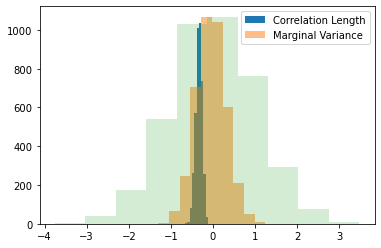

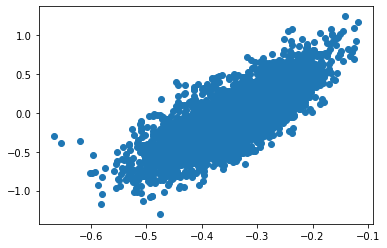

In [6]:
plt.hist(np.log10(np.array(jgp.samples["corr_len"])), label = "Correlation Length")
plt.hist(np.log10(np.array(jgp.samples["marg_var"])),alpha=0.5, label="Marginal Variance")
plt.hist(np.random.randn(4000), alpha=0.2)
plt.legend()
plt.show()

plt.scatter(np.log10(np.array(jgp.samples["corr_len"])), np.log10(np.array(jgp.samples["marg_var"])))


In [7]:
%%time
preds, y_hat, lower, upper = jgp.bayes_predict(px)


This is currently really slow - 
 a minute or two for predicting 50 points from 4000 samples with 20 observations.
Just a heads up.
CPU times: user 33.8 s, sys: 66.1 ms, total: 33.8 s
Wall time: 33.9 s


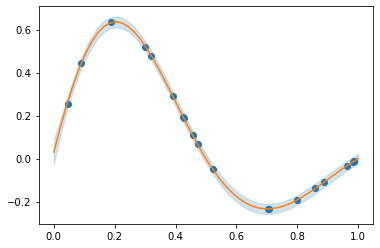

In [8]:
plt.scatter(x, y,c="C0")
plt.plot(px, y_hat, c="C1")
plt.fill_between(px, lower, upper, alpha=0.2, color="C0")
plt.show()


In [9]:
%%time
preds, y_hat, lower, upper = jgp.bayes_predict(px, derivative="df/dx")


This is currently really slow - 
 a minute or two for predicting 50 points from 4000 samples with 20 observations.
Just a heads up.
CPU times: user 1min 37s, sys: 178 ms, total: 1min 37s
Wall time: 1min 37s


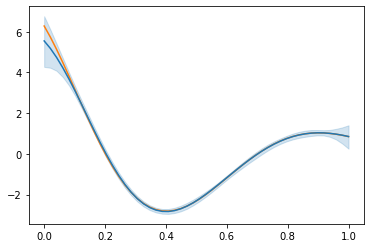

CPU times: user 77.8 ms, sys: 2.55 ms, total: 80.4 ms
Wall time: 79 ms


In [10]:
%%time
plt.plot(px, -2*np.exp(-2*px)*np.sin(px*2.*np.pi) + np.exp(-2*px)*np.cos(px*2.*np.pi)*2*np.pi, c="C1")
plt.plot(px, y_hat, c="C0")
plt.fill_between(px, lower, upper, alpha=0.2, color="C0")
plt.show()


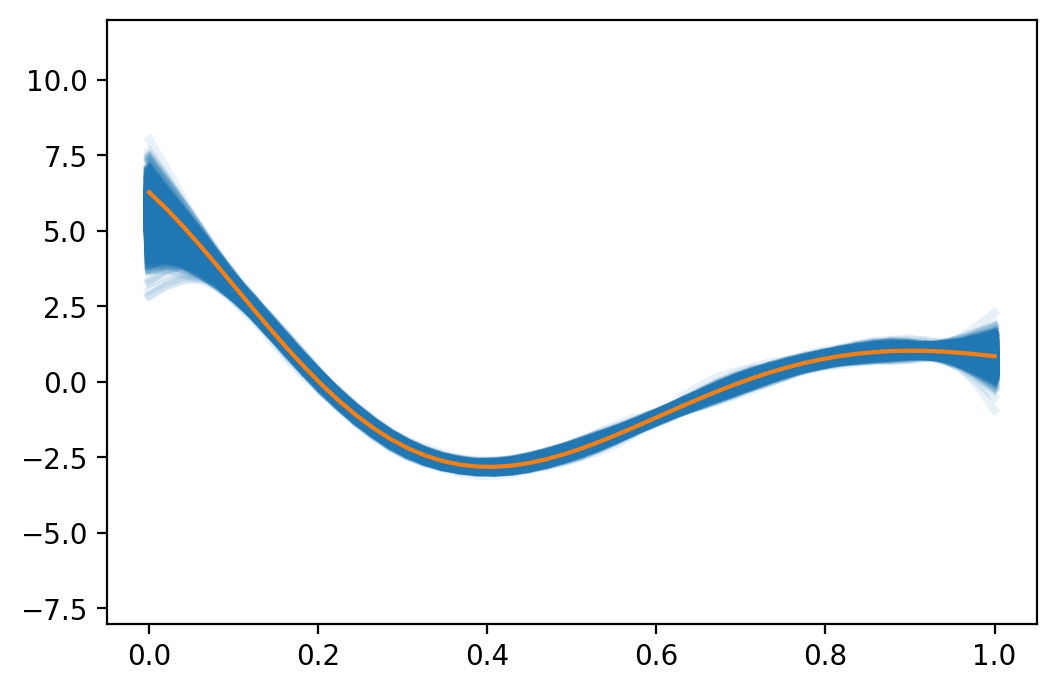

CPU times: user 3.6 s, sys: 26.4 ms, total: 3.63 s
Wall time: 3.63 s


In [11]:
%%time
plt.figure(dpi=200)
plt.plot(px, preds.T, c="C0", alpha=0.1, linewidth=3)
plt.plot(px, -2*np.exp(-2*px)*np.sin(px*2.*np.pi) + np.exp(-2*px)*np.cos(px*2.*np.pi)*2*np.pi, c="C1")
plt.ylim(-8,12)
plt.show()


In [12]:
%%time
preds, y_hat, lower, upper = jgp.bayes_predict(px, derivative="d2f/dx2")


This is currently really slow - 
 a minute or two for predicting 50 points from 4000 samples with 20 observations.
Just a heads up.
CPU times: user 4min 58s, sys: 678 ms, total: 4min 58s
Wall time: 4min 59s


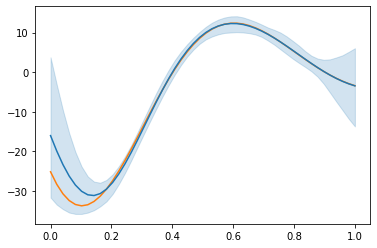

In [13]:
plt.plot(px, 4*np.exp(-2*px)*np.sin(px*2.*np.pi) + 
         -4*np.pi*np.exp(-2*px)*np.cos(px*2.*np.pi) + 
         -2*np.exp(-2*px)*np.cos(px*2.*np.pi)*2*np.pi - 
         np.exp(-2*px)*np.sin(px*2.*np.pi)*4*np.pi**2, c="C1")

plt.plot(px, y_hat, c="C0")
plt.fill_between(px, lower, upper, alpha=0.2, color="C0")
plt.show()

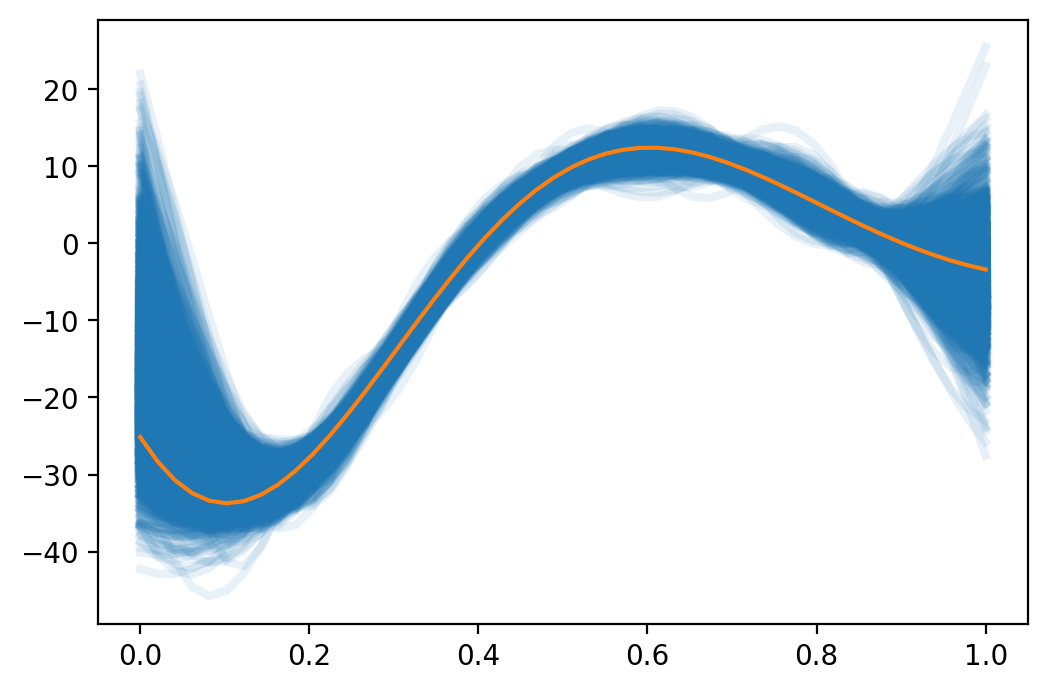

CPU times: user 3.67 s, sys: 13.9 ms, total: 3.69 s
Wall time: 3.69 s


In [14]:
%%time
plt.figure(dpi=200)
plt.plot(px, preds.T, c="C0", alpha=0.1, linewidth=3)
plt.plot(px, 4*np.exp(-2*px)*np.sin(px*2.*np.pi) + 
         -4*np.pi*np.exp(-2*px)*np.cos(px*2.*np.pi) + 
         -2*np.exp(-2*px)*np.cos(px*2.*np.pi)*2*np.pi - 
         np.exp(-2*px)*np.sin(px*2.*np.pi)*4*np.pi**2, c="C1")
plt.show()


In [15]:
def truef(x):
    return np.sin(x[:,0]*2 *np.pi) + x[:,1]

def truedfdx(x):
    #return -np.sin(x[:,0]*2 *np.pi)*4 *np.pi**2
    return np.cos(x[:,0]*2 *np.pi)*2 *np.pi

def truedfdy(x):
    #return 1.*np.zeros_like(x[:,0])
    return 1.*np.ones_like(x[:,0])


In [16]:
n  = 30
pn = 400

x  = np.random.rand(n,2)
pv = np.linspace(0,1,20)
px = np.array([(x, y) for x in pv for y in pv])
y  = truef(x)


In [17]:
jgp = JaxDerviativeGP(x, y)


In [18]:
jgp.bayes_train()

/Users/mikegros/Projects/Nuclei/dfdjaxGP/dfdjaxGP/gp.py:106: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|███████████████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 1092.20it/s, 3 steps of size 4.86e-01. acc. prob=0.93]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  corr_len      0.57      0.05      0.57      0.50      0.65    902.62      1.00
  marg_var      1.92      1.01      1.70      0.61      3.22    974.54      1.00

Number of divergences: 0


In [19]:
%%time
py   = truef(px)

vmin = np.min(py)
vmax = np.max(py)

preds, y_hat, lower, upper = jgp.bayes_predict(px)


This is currently really slow - 
 a minute or two for predicting 50 points from 4000 samples with 20 observations.
Just a heads up.
CPU times: user 18min 18s, sys: 13.6 s, total: 18min 32s
Wall time: 2min 18s


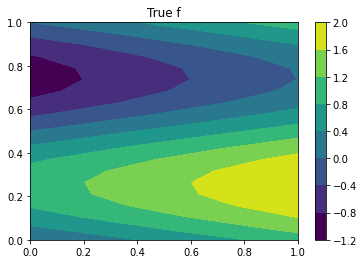

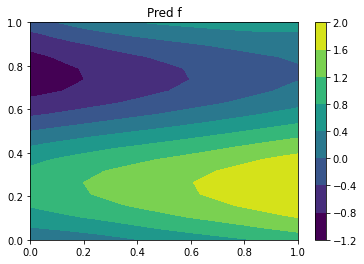

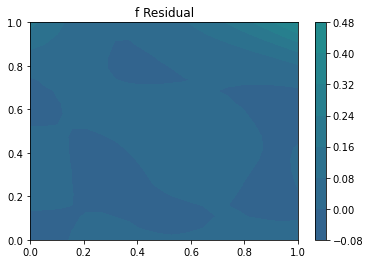

In [20]:
plt.contourf(pv, pv, py.reshape(20,20), vmin=vmin, vmax=vmax)
plt.title("True f")
plt.colorbar()
plt.show()

plt.contourf(pv, pv, y_hat.reshape(20,20), vmin=vmin, vmax=vmax)
plt.title("Pred f")
plt.colorbar()
plt.show()

plt.contourf(pv, pv, (py - y_hat).reshape(20,20), vmin=vmin, vmax=vmax)
plt.title("f Residual")
plt.colorbar()
plt.show()


In [21]:
%%time 

py   = truedfdx(px)

vmin = np.min(py)
vmax = np.max(py)

preds, y_hat, upper, lower = jgp.bayes_predict(px, derivative="df/dx")

This is currently really slow - 
 a minute or two for predicting 50 points from 4000 samples with 20 observations.
Just a heads up.
CPU times: user 34min 6s, sys: 29.9 s, total: 34min 36s
Wall time: 4min 17s


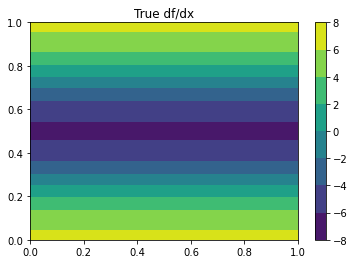

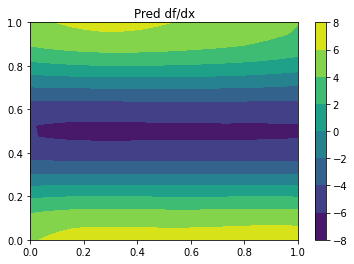

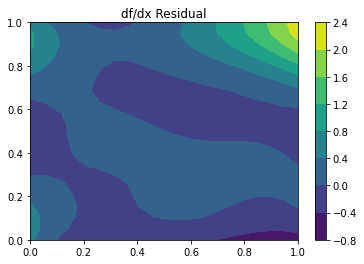

In [22]:
plt.contourf(pv, pv, py.reshape(20,20))
plt.title("True df/dx")
plt.colorbar()
plt.show()

plt.contourf(pv, pv, y_hat.reshape(20,20))
plt.title("Pred df/dx")
plt.colorbar()
plt.show()

plt.contourf(pv, pv, (py - y_hat).reshape(20,20))
plt.title("df/dx Residual")
plt.colorbar()
plt.show()


In [ ]:
py   = truedfdy(px)

vmin = np.min(py)
vmax = np.max(py)

preds, y_hat, upper, lower = jgp.bayes_predict(px, derivative="df/dy")

This is currently really slow - 
 a minute or two for predicting 50 points from 4000 samples with 20 observations.
Just a heads up.


In [ ]:
plt.contourf(pv, pv, py.reshape(20,20))
plt.title("True df/dy")
plt.colorbar()
plt.show()

plt.contourf(pv, pv, y_hat.reshape(20,20))
plt.title("Pred df/dy")
plt.colorbar()
plt.show()

plt.contourf(pv, pv, (py - y_hat).reshape(20,20))
plt.title("df/dy Residual")
plt.colorbar()
plt.show()
